# Image Caption Generation
### the project is divided into different Sections
1. prepare the environment on google colab(install and import necessary library, fetch the dataset, prepare the structure of the project)
2. Exploratory Data Analysis
3. Extract Features from Images
4. Perpocessing Text data
5. Model Creation
6. Visulaize the  Result

The Dataset that will be used is flickr8k
Dataset link: https://www.kaggle.com/adityajn105/flickr8k

The Models that will be used are:
VGG16 (to extract features from image)

CNN-LSTM (to generate caption for image)

install kaggle library

In [1]:
!pip install kaggle

get kaggle API token

In [2]:
from google.colab import files
# function to upload necessary files
def upload_file():
    files.upload()

In [3]:
# uplaod file that contains the API token
upload_file()

Saving kaggle.json to kaggle.json


fetch dataset from kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/ kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k



100% 1.04G/1.04G [00:56<00:00, 16.6MB/s]

100% 1.04G/1.04G [00:56<00:00, 19.6MB/s]


Unzip the file that contain the dataset

In [6]:
from zipfile import ZipFile
file_name = '/content/flickr8k.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("done")

done


Create your directories

In [7]:
!mkdir /content/flickr8k
!mkdir /content/work

In [8]:
import os
import shutil

source = '/content'
destination = '/content/flickr8k'

# gather all files
allfiles = ['Images', 'captions.txt']

# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)

In [9]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/work'

### Import Necessary Library

In [10]:
import os
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding,Dropout, add
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [11]:
data_df = pd.read_csv("/content/flickr8k/captions.txt", sep=',')

In [12]:
data_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [13]:
data_df.image.value_counts()

1000268201_693b08cb0e.jpg    5
3388094307_5a83be64a5.jpg    5
3393394134_0caac47e1c.jpg    5
3393343330_b13df4d8ec.jpg    5
3393152604_27bd1037f2.jpg    5
                            ..
2699733386_c346c87ea6.jpg    5
2699426519_228719b1db.jpg    5
2699342860_5288e203ea.jpg    5
2699125097_c6801d80ed.jpg    5
997722733_0cb5439472.jpg     5
Name: image, Length: 8091, dtype: int64

In our dataset each image has 5 captions

In [14]:
from wordcloud import WordCloud
# function to plot word cloud
def word_cloud_plot(text_data):
    text = ' '
    for row in text_data:
        text = text + row
    plt.figure(figsize=(16, 12))
    word_cloud = WordCloud(width = 700, height = 300, random_state=1, collocations= True, background_color = 'white', colormap='Set2').generate(text)
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title("strength of word in complete data corpus", fontsize = 30)
    plt.show()

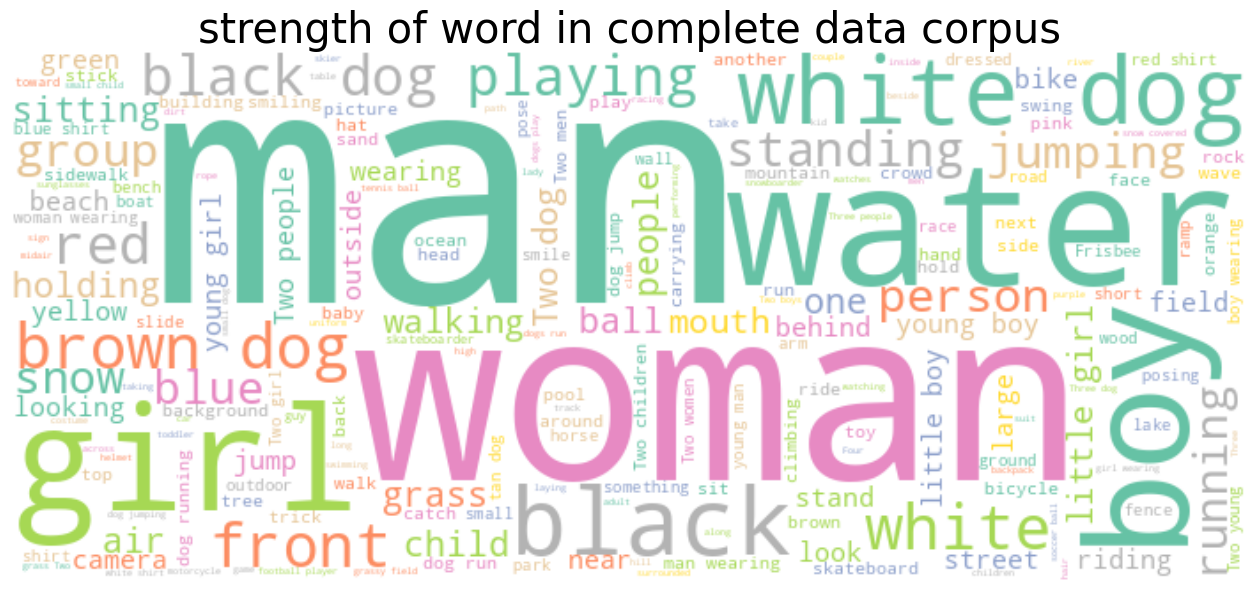

In [15]:
word_cloud_plot(data_df.caption)

  0%|          | 0/3 [00:00<?, ?it/s]

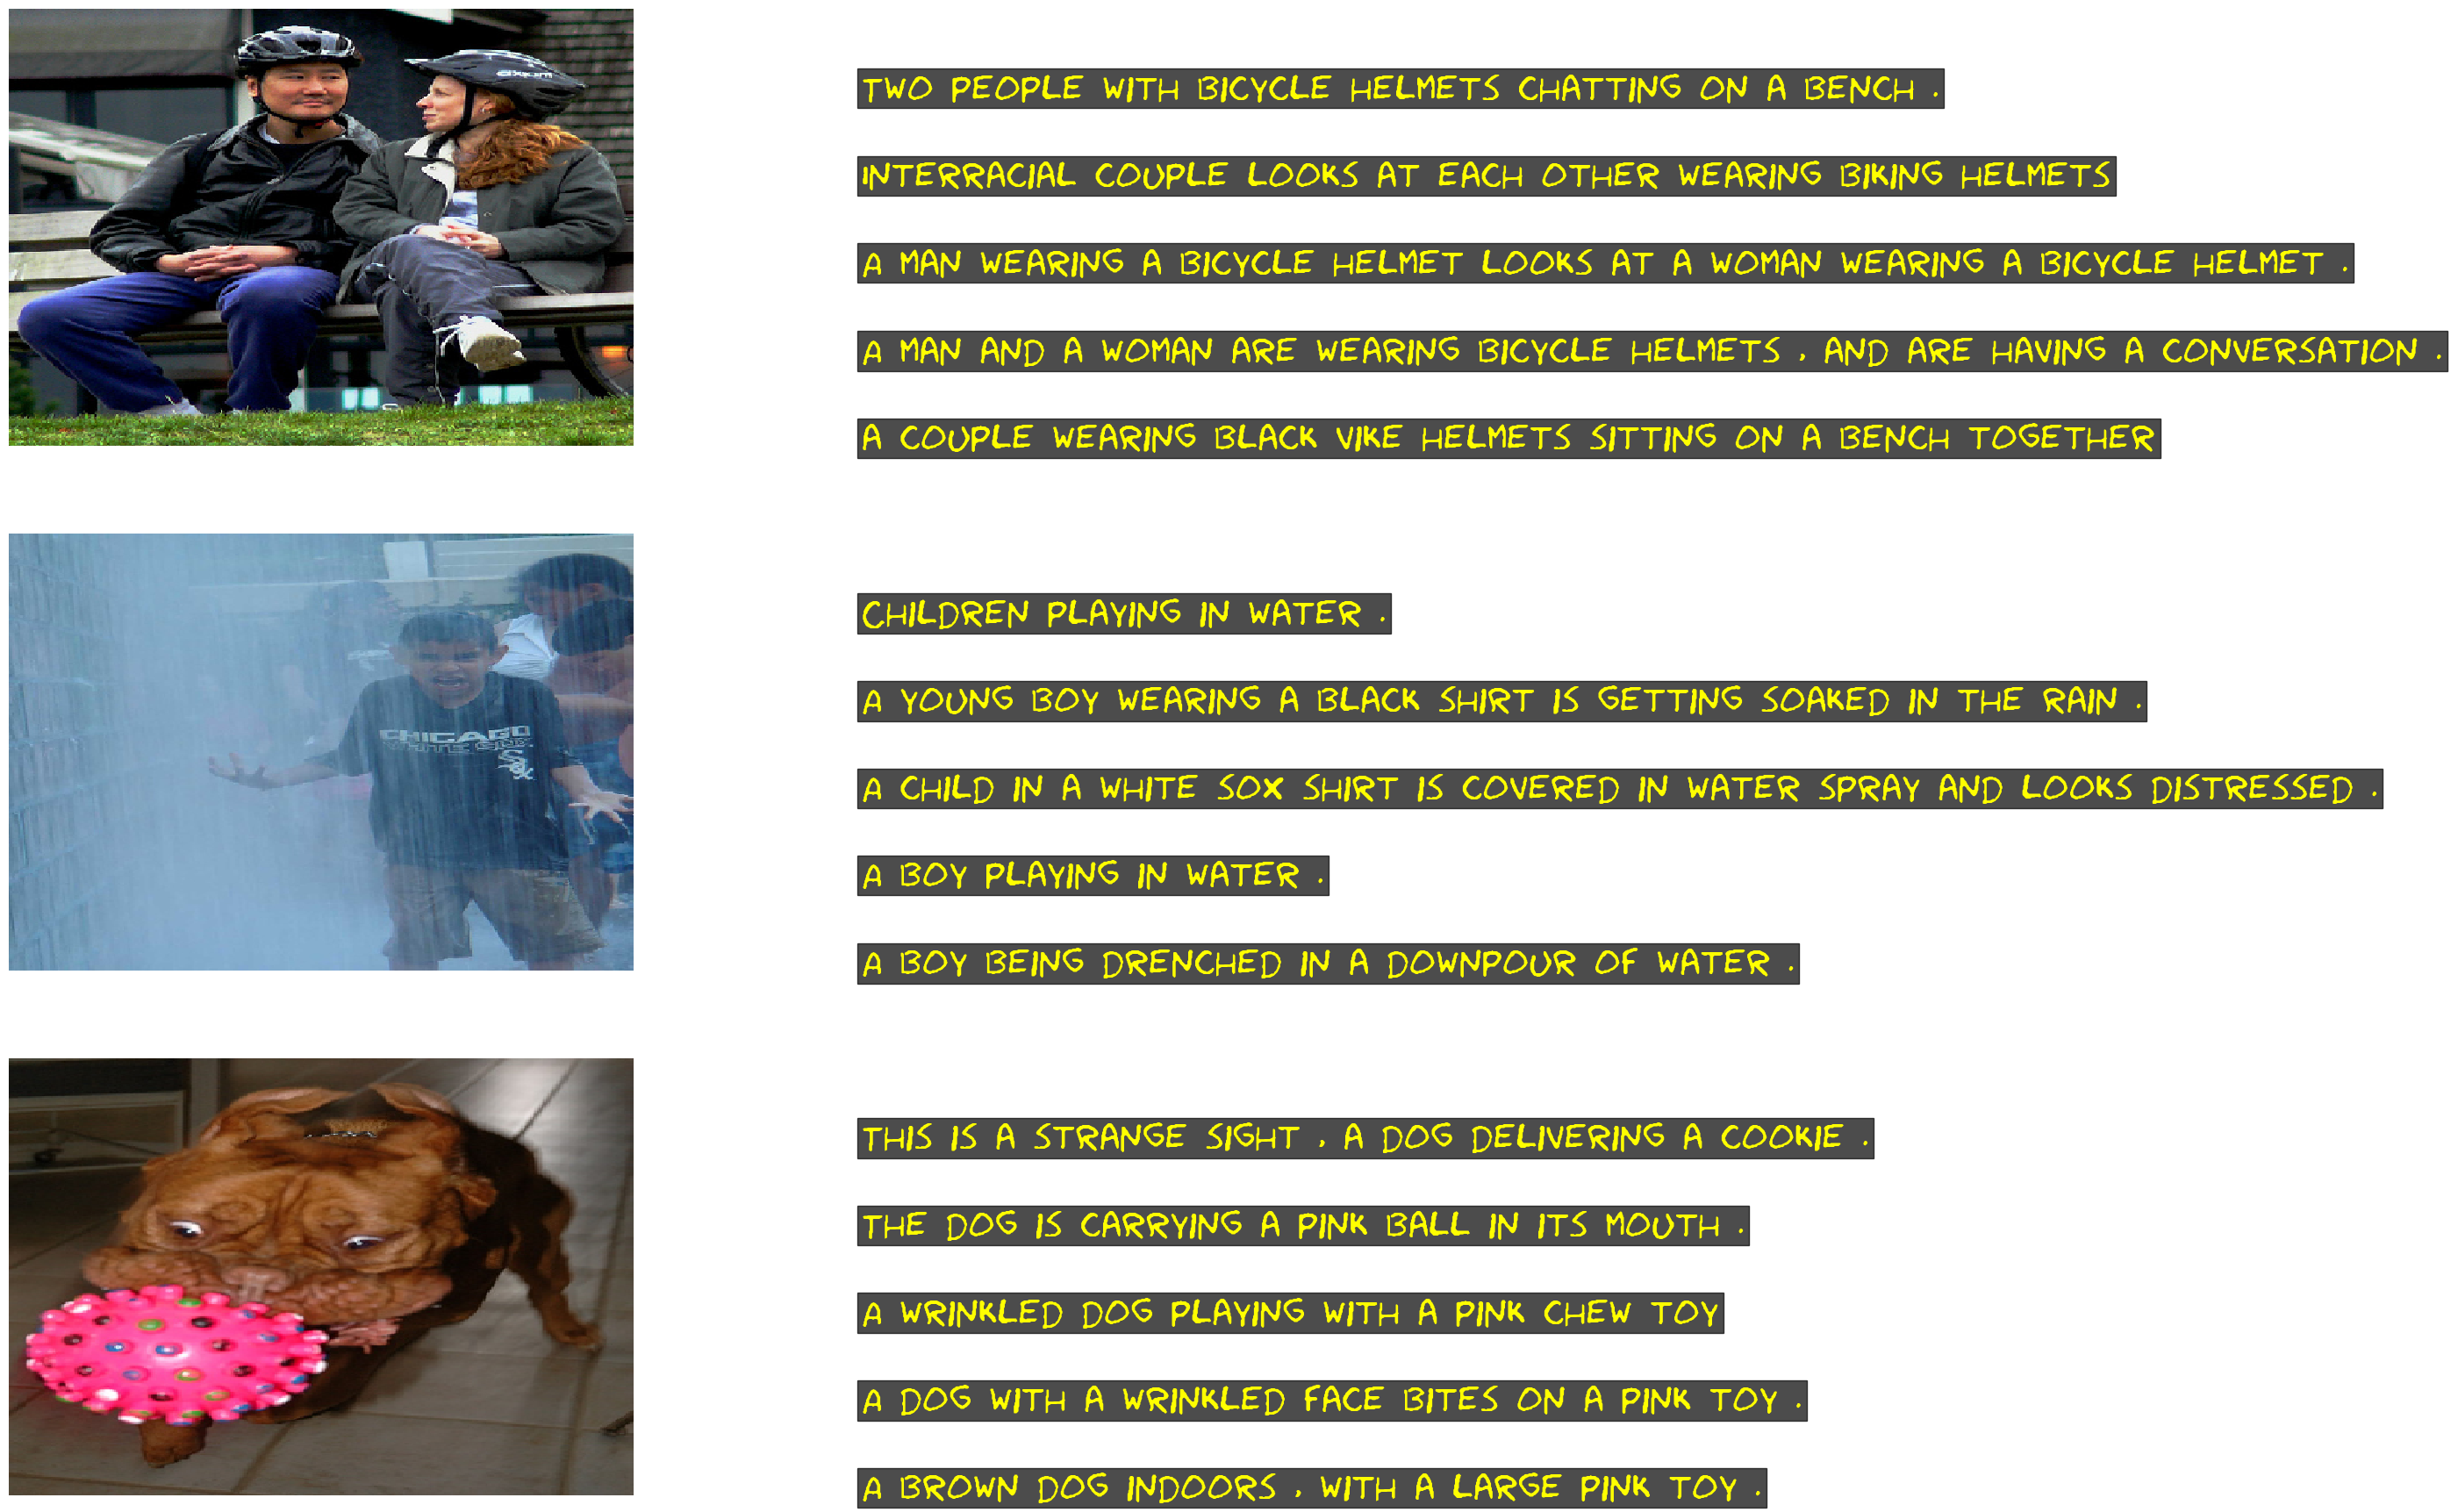

In [16]:
def image_caption_plotter(data):
    npic = 3
    target_size = (350, 500, 3)
    count = 1
    fig = plt.figure(figsize=(25, 22))
    for file in tqdm(random.sample(list(data['image']), npic)):
        captions = list(data['caption'].loc[data['image'] == file].values)
        image_load = load_img('/content/flickr8k/Images/' + file, target_size = target_size)
        ax = fig.add_subplot(npic, 2, count)
        ax.axis('off')
        ax.imshow(image_load, interpolation='nearest')
        count += 1
        ax = fig.add_subplot(npic, 2, count)
        ax.axis('off')
        ax.set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax.text(0, i, caption, fontsize = 30, fontfamily= 'fantasy', bbox=dict(facecolor='black', alpha=0.7), color='yellow')
        count += 1
        plt.grid(None)
    plt.show()

image_caption_plotter(data_df)

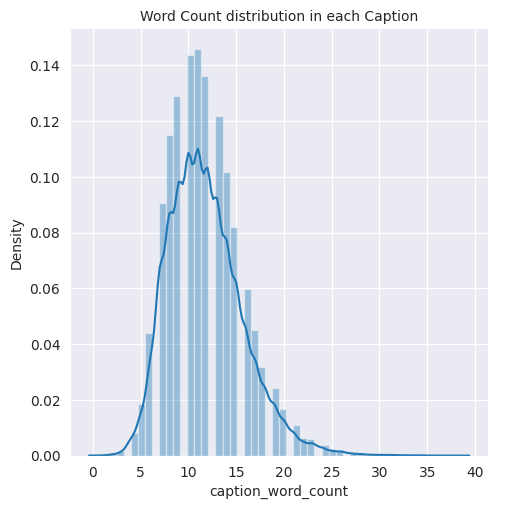

In [17]:
# create caption word count column
data_df['caption_word_count'] = data_df['caption'].apply(lambda caption: len(caption.split()))

sns.set_style('darkgrid')
sns.FacetGrid(data_df, height = 5).map(sns.distplot, 'caption_word_count').add_legend()
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.title('Word Count distribution in each Caption', fontsize = 10)
plt.show()

## Extract features from images  

we will use VGG16 model to extract features

In [18]:
def customized_vgg16_model():
    # get VGG16 model
    model = VGG16(weights='imagenet', include_top=True)
    # customize the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    return model


model = customized_vgg16_model()
model.summary()


553467096/553467096 [==============================] - 25s 0us/step

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

                                          

If you store features extraction of images in file you can skip these two next cell. otherwise, you should run the next two cell, so you can extract the features from the image and store in a file but this process will take a time.

In [ ]:
# extract features form image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    image_path = directory + '/' + img_name
    image = load_img(image_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for VGG16
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store  feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

Store the images features in pickle file so you can used when you want without rerun the cell above

In [ ]:
# store features in pickls
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Now, you can store the file in your goole drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Move features.pkl to google drive. the reason of this is goole colab restart in in each couple of hours and the files go away

In [20]:
import shutil # a library used to save file in google drive and load form it

In [21]:
colab_link = "/content/features.pkl"
gdrive_link = "/content/drive/MyDrive/image_caption_project/"
# shutil.copy(colab_link, gdrive_link)

Load files from goole drive to your directory

In [22]:
colab_link = "/content/work/"
gdrive_link = "/content/drive/MyDrive/image_caption_project/features.pkl"
shutil.copy(gdrive_link, colab_link)

'/content/work/features.pkl'

In [23]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## perpocessing Text data

### load the captions data

In [24]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    caption_doc = f.read()

In [25]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(caption_doc.split("\n")):
    # split the line by comma(,)
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convet caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

### data cleaning

In [26]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convet to lowercase
            caption = caption.lower()
            # detele digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additonal spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tages to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [27]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [28]:
# preprocess the text
clean(mapping)

In [29]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [30]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [31]:
len(all_captions)

40455

In [32]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [33]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8485


In [34]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [35]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [36]:
# create data generator to get data in batch (avoid session crech)
def data_generator(data_key,
                   mapping,
                   features,
                   tokenizer,
                   max_length,
                   vocab_size,
                   batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_key:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq =to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequence
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n = 0

# Model Creation

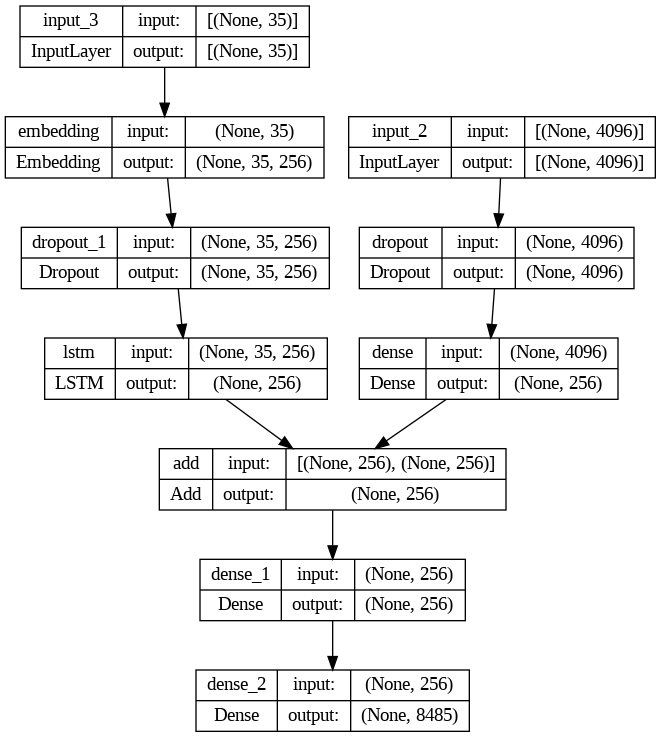

In [38]:
def image_caption_model():
    # encoder model
    # image feature model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence feature layers
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # image caption model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    return model

model = image_caption_model()
#plot the model
plot_model(model, show_shapes=True)

In [28]:
# train the model
epochs = 25
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train,
                               mapping,
                               features,
                               tokenizer,
                               max_length,
                               vocab_size,
                               batch_size)

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 77s 594ms/step - loss: 5.5919

113/113 [==============================] - 55s 491ms/step - loss: 4.4555

113/113 [==============================] - 56s 496ms/step - loss: 3.8437

113/113 [==============================] - 55s 490ms/step - loss: 3.5407

113/113 [==============================] - 55s 483ms/step - loss: 3.3304

113/113 [==============================] - 56s 498ms/step - loss: 3.1700

113/113 [==============================] - 55s 490ms/step - loss: 3.0395

113/113 [==============================] - 56s 490ms/step - loss: 2.9278

113/113 [==============================] - 54s 480ms/step - loss: 2.8298

113/113 [==============================] - 54s 481ms/step - loss: 2.7495

113/113 [==============================] - 56s 497ms/step - loss: 2.6801

113/113 [==============================] - 55s 483ms/step - loss: 2.6211

113/113 [==============================] - 55s 489ms/step - loss: 2.5638

113/113 [=============================

Save the model so you can use it later

In [29]:
# save the model
model.save(WORKING_DIR + "/image_caption_generator_model.h5")

Move it to your drive

In [39]:
colab_link = WORKING_DIR + "/image_caption_generator_model.h5"
gdrive_link = "/content/drive/MyDrive/image_caption_project/"
#shutil.copy(colab_link, gdrive_link)

Load the model from google drive

In [40]:
colab_link = "/content/work/"
gdrive_link = "/content/drive/MyDrive/image_caption_project/image_caption_generator_model.h5"
shutil.copy(gdrive_link, colab_link)

'/content/work/image_caption_generator_model.h5'

In [41]:
# load the model
model = tf.keras.models.load_model("/content/work/image_caption_generator_model.h5")

## generate caption for the image

In [42]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [43]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # convert index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generate next word
        in_text += " " + word
        # stop if we reach end tag
        if word == "endseq":
            break
    return in_text

In [44]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split to words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0 ,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0, 0.5 ,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.538787

BLEU-2: 0.200582


## Visulaize the  Result

In [45]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    #image_name = "1002674143_1b742ab4b8.jpg"
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    print('------------------------------------------------------')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("----------------------predicted------------------------")
    print(y_pred)
    plt.imshow(image)

------------------------------------------------------

startseq black dog and spotted dog are fighting endseq

startseq black dog and tri-colored dog playing with each other on the road endseq

startseq black dog and white dog with brown spots are staring at each other in the street endseq

startseq two dogs of different breeds looking at each other on the road endseq

startseq two dogs on pavement moving toward each other endseq

----------------------predicted------------------------

startseq black dog and white dog are playing on the street endseq


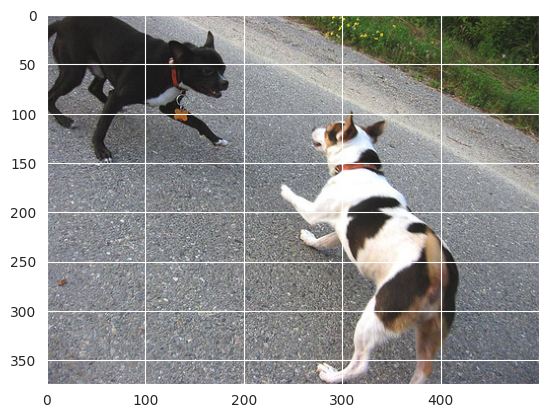

In [46]:
generate_caption('1001773457_577c3a7d70.jpg')